# Capstone project - Battle of Neighbourhoods

# Identification of less Tennis facilitated Neighborhoods in North York, Toronto

## 1. Introduction

#### 1.1 Background:

In preparation for the Summer olympics 2024, Sports Authority of Canada in collaboration with each local government and individual sports Federations assessing the current facilities and planning to start improve the sports facilities all over Canada within two years. Their aim is not just to get medals in Olympics or international competitions, their first priority is to make awarenes among students  about the importance of sports activities and how it will help them to keep a healthy body and mind. As the most populated city in Canada, they want to start their piolet project  around Toronto. This study is for Tennis Federation of canada who wants to study the current facilities in Toronto and start new Tennis facilities at most needy areas.  

#### 1.2 Business Problem:

This assignment is to identify the locations for new Tennis facilities in Toronto neighbourhoods. Since this facility is mainly for students in schools, colleges and Universities, need to identify the educational institutions around Toronto and the current Tennis facility in the regions. Then find out where the  Tennis facility with respect to number of schools is very low. Their aim is to increase the proportion of Tennis facility to number of schools to 20%. It means, for 5 schools together at least one Facility for playing Tennis. Initially considering the neighborhoods in Noth York Borough for assessment.

#### 1.3 Stakeholders: 

This project for identifying the locations for new Tennis facility in oronto, is very  useful  for identifying low facility and high requirement area. Sports Authority, Tennis Federation and local governments who implement new facilities in their area are stakeholders  for this project. Certainly this will help the students to prove the necessity of a new Tennis facility in areas of low facility.  



#### Import all necessary libraries

In this section importin all necessary libraries required for data capture, data analysis and visualization.

In [1]:
#import all necessary libraries

import pandas as pd
import numpy as np
import json # library to handle JSON files


#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print('Matplotlib version: ', mpl.__version__) # >= 2.0.0
# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

%matplotlib inline 

Matplotlib version:  3.0.2
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    altair-3.1.0               |           py36_0         724 KB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.2 MB

The foll

## 2. Data Acquisition and Preparation

#### 2.1 Data Acquisition: 

Since the area of study is Toronto and neighbourhoods, to get the neighbourhood details, use Wikipedia as the source. Downloaded the data in html format. But this data doesn’t include geographical coordinates. To get the geographical coordinates corresponding to each neighborhood, used the facility in website (Toronto neighborhood Geospatial_data). This is a csv format file. This study requires the details of schools and Tennis facilities in each neighborhood to identify the most required locations for new Tennis facility. I am using Foursquare data (Foursquare) for venues to get current details of schools and Tennis facilities in neighborhoods in North York borough (Toronto).

#### 2.2 Data cleaning: 

Since the source of data for this project is from different sources and in different format, to build a clean data frame for further analysis, different data cleaning activities have to be done. The data scraped from Wikipedia for data related to Toronto neighborhood, contains  neighborhood with not assigned boroughs. Since our study is about the neighborhoods in North York only, neighborhoods without borough assigned were dropped to confirm the selected neighborhoods belong to North York itself.  Since the geographical coordinates are towards postal codes, to avoid duplications in Geographical coordinates and postal codes in data, combined neighborhoods with same postal codes and made postal codes unique. 
The venues list obtained from foursquare for schools include some other offices like school board and those ones which are not educational institutions were dropped. In Tennis venues list obtained from Foursquare, include shops which purchase Tennis goods also were removed from data.

#### 2.3 Data preparation/ Feature Selection:

Since the problem is to find out the low Tennis facilitated schools in neighboring areas, after validating various parameters, considered schools and Tennis facilities in 500M from each neighborhood center. Distance from neighborhood center is important feature in this study. But distance parameter in venues data of Tennis facilities and schools, obtained from Foursquare, is continuous. For future analysis based on distance, the continuous variable distance is binned to put it under 4 categories based on distance range.  Another categorization did was based on type of school.  Various school types categorized into two groups - ‘High school and below’ and ‘Above High School’ which include all colleges, universities and other institutions.  After completing data cleaning and feature selection, conducted various exploratory and descriptive statistics and visualization to learn about the overall quality of data and to get a preliminary idea about the relationship between selected features.   


#####  Prepare the data for Toronto. Toronto neighborhood geographical coordiantes are not readily available.  
##### Read data about postcode, and neighbourhood in Toronto from wikipedia

In [238]:
#Prepare the data for Toronto. Toronto neighborhood geographical coordiantes are not readily available.  
#Read data about postcode, and neighbourhood in Toronto from wikipedia
wikilink="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
TWtable = pd.read_html(wikilink,header=0)
TWdf=pd.DataFrame(TWtable[0])
#print(TWdf.shape)
#print(TWdf.head(10))
# Data cleansing-part1
# Drop all rows with Not Assigned Borough.
TWdf.drop(TWdf[TWdf.Borough == 'Not assigned'].index, inplace=True)
I=len(TWdf)
#print(I)
TWdf.index=range(I)
#TWdf.head(20)
# Data cleansing-part2
#Combine Neighborhoods with same Postcode and Assign Borough name to Not assigned Neighborhoods 
TWgp1=TWdf.groupby('Postcode')['Neighbourhood'].apply(lambda x: "%s" % ', '.join(x))
TWgp2=TWdf.groupby('Postcode')['Borough'].apply(np.unique)
TWNgp = pd.concat([TWgp2, TWgp1],axis=1)
TWNew = TWNgp.reset_index() 
TWNew['Borough'] = TWNew.Borough.apply(', '.join)
#print(TWNew.tail(20))
TWNew['Neighbourhood'].replace("Not assigned", TWNew['Borough'], inplace=True)
#print(TWNew.tail(20))
print ("Number of Rows and Columns in new data frame : ",TWNew.shape)

Number of Rows and Columns in new data frame :  (103, 3)


#### Get geographic cordinates for neighborhoods

In [243]:
#Read geographical coordinates of each postal code using the link http://cocl.us/Geospatial_data
Geolink= "http://cocl.us/Geospatial_data"
Geodf = pd.read_csv(Geolink,header=0)
Geodf=pd.DataFrame(Geodf)
#Join the two dataframes neighborhoods and Geographical coordinates which will help us to mark the neighborhood in a map.   
Newdf = TWNew.join(Geodf)
Newdf.drop(columns=['Postal Code'],inplace=True)
Newdf.shape

(103, 5)

In [363]:
# Filter the data for North york borough only and rest index
Newdf['Borough'].unique()
NY_df=Newdf[Newdf.Borough=='North York']
NY_df.reset_index(inplace=True)
NY_df.drop(columns=['index','Postcode'],inplace=True)
print(NY_df.head())
print("Number of Neighbourhoods in North York:" ,NY_df['Neighbourhood'].count())
latitude = 43.7615
longitude = -79.4111
print('The geograpical coordinate of North York are {}, {}.'.format(latitude, longitude))

      Borough                 Neighbourhood   Latitude  Longitude
0  North York             Hillcrest Village  43.803762 -79.363452
1  North York  Fairview, Henry Farm, Oriole  43.778517 -79.346556
2  North York               Bayview Village  43.786947 -79.385975
3  North York      Silver Hills, York Mills  43.757490 -79.374714
4  North York       Newtonbrook, Willowdale  43.789053 -79.408493
Number of Neighbourhoods in North York: 24
The geograpical coordinate of North York are 43.7615, -79.4111.


#### Draw the Toronto map with selected north york neighborhoods

In [246]:
# Map toronto with North York neighborhoods
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(NY_df['Latitude'], NY_df['Longitude'], NY_df['Borough'], NY_df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### input four square credentials and get venue infirmation from Four square website

In [247]:
#inputting credentials
CLIENT_ID = 'YVCLODVVIZU1FWNEIJGT1B3ARFMR0QXP4KAFABYG0LBZA3KO' 
CLIENT_SECRET = 'IOK254GFL1UDJ5V35D1ORKGZVN1LUSJLDB3GU0MT1WKOQIJS' 
VERSION = '20180605' # Foursquare API version

function that extracts the category of the venue

In [248]:

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']



Get venue details for each neighborhood and merge all venue details to one file 

In [249]:
# Find schools and Tennis facilities within 1000M radius
search_query = 'School,Tennis'
radius = 1000
LIMIT=500
Total_df=pd.DataFrame(columns=['name', 'categories', '', 'address', 'cc', 'city', 'country',
       'distance', 'formattedAddress', 'labeledLatLngs', 'lat', 'lng', 'state',
       'id'])

for index, row in NY_df.iterrows():
    i=index
    latitude=NY_df.iloc[i,2]
    longitude=NY_df.iloc[i,3]
    nhd=NY_df.iloc[i,1]
    dfv=[]
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
    results = requests.get(url).json()
    #print(results)
    # assign relevant part of JSON to venues
    venues = results['response']['venues']
    
    #print(venues)
    # tranform venues into a dataframe
    dataframe = json_normalize(venues)
    
    
    # keep only columns that include venue name, and anything that is associated with location
    filtered_columns = ['name', 'categories',''] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
    Tennis_filtered = dataframe.loc[:, filtered_columns]

    # filter the category for each row
    Tennis_filtered['categories'] = Tennis_filtered.apply(get_category_type, axis=1)

    # clean column names by keeping only last term
    Tennis_filtered.columns = [column.split('.')[-1] for column in Tennis_filtered.columns]
      
    #Concat new neighborhood venues to the total dataframe
    Tennis_filtered.set_index([[nhd]*len(Tennis_filtered)], inplace=True)
    Tennis_filtered.index.name = 'Neighborhood'
    Tennis_filtered.reset_index(level=['Neighborhood'])
    #print(Tennis_filtered)
    Total_df=Total_df.append(Tennis_filtered)


Total_df['Neighborhood'] = Total_df.index
Total_df.reset_index(level=0, inplace=True)
Total_df['distance']=pd.to_numeric(Total_df['distance'])
print(Total_df.shape)
#print(Total_df[['Neighborhood','name']])
print(Total_df.columns)
print(Total_df.dtypes)


/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


(194, 19)
Index(['index', '', 'address', 'categories', 'cc', 'city', 'country',
       'crossStreet', 'distance', 'formattedAddress', 'id', 'labeledLatLngs',
       'lat', 'lng', 'name', 'neighborhood', 'postalCode', 'state',
       'Neighborhood'],
      dtype='object')
index                object
                    float64
address              object
categories           object
cc                   object
city                 object
country              object
crossStreet          object
distance              int64
formattedAddress     object
id                   object
labeledLatLngs       object
lat                 float64
lng                 float64
name                 object
neighborhood         object
postalCode           object
state                object
Neighborhood         object
dtype: object


In [250]:
# Drop unwanted columns from final data frame
Total_df.drop(columns=['address','cc','city', 'country','crossStreet','formattedAddress','labeledLatLngs','neighborhood','postalCode', 'state'],inplace=True)
Total_df.drop([Total_df.columns[0]],axis='columns')
Total_df.reset_index()
print(Total_df.head())


               index                        categories  distance  \
0  Hillcrest Village NaN                   High School       227   
1  Hillcrest Village NaN                  Tennis Court       579   
2  Hillcrest Village NaN            Athletics & Sports       297   
3  Hillcrest Village NaN                        School       714   
4  Hillcrest Village NaN  General College & University       456   

                         id        lat        lng  \
0  4bf93961b182c9b6198e785a  43.804115 -79.366237   
1  4fb2f0d6e4b0fb410b80cd27  43.798561 -79.363506   
2  518815ab498e99d0bb98ac96  43.805068 -79.366677   
3  4dbed94c6a23a3c473ae2f09  43.806799 -79.355611   
4  4cb4c68e770fef3b060bb113  43.806337 -79.359022   

                                  name       Neighborhood  
0        A.Y. Jackson Secondary School  Hillcrest Village  
1                Hillcrest Tennis Club  Hillcrest Village  
2  A.Y. Jackson Secondary School Track  Hillcrest Village  
3          Highland Junior High 

In [252]:
# Drop index column and NaN index column
Total_df.reset_index
#Run this code two times for dropping unwanted 2 index columns
#Total_df.drop([Total_df.columns[0]],axis='columns',inplace=True)
print(Total_df.head())

                     categories  distance                        id  \
0                   High School       227  4bf93961b182c9b6198e785a   
1                  Tennis Court       579  4fb2f0d6e4b0fb410b80cd27   
2            Athletics & Sports       297  518815ab498e99d0bb98ac96   
3                        School       714  4dbed94c6a23a3c473ae2f09   
4  General College & University       456  4cb4c68e770fef3b060bb113   

         lat        lng                                 name  \
0  43.804115 -79.366237        A.Y. Jackson Secondary School   
1  43.798561 -79.363506                Hillcrest Tennis Club   
2  43.805068 -79.366677  A.Y. Jackson Secondary School Track   
3  43.806799 -79.355611          Highland Junior High School   
4  43.806337 -79.359022              Cliffwood Public School   

        Neighborhood  
0  Hillcrest Village  
1  Hillcrest Village  
2  Hillcrest Village  
3  Hillcrest Village  
4  Hillcrest Village  


### Details

##### identify any categories other than schools, colleges , universities and tesnnis facilities present in the data frame. Remove those wrong categories from data.  

In [254]:
Total_df.groupby('categories').count()

,distance,id,lat,lng,name,Neighborhood
categories,,,,,,
Acupuncturist,1,1,1,1,1,1
Art Gallery,2,2,2,2,2,2
Athletics & Sports,4,4,4,4,4,4
Building,1,1,1,1,1,1
Church,1,1,1,1,1,1
College & University,1,1,1,1,1,1
College Academic Building,3,3,3,3,3,3
College Administrative Building,3,3,3,3,3,3
College Arts Building,2,2,2,2,2,2


###### Remove unwanted categories using drop method


In [255]:
cattodrop=Total_df[(Total_df['categories'] == 'Acupuncturist') |
                   (Total_df['categories'] == 'Art Gallery') | 
                   (Total_df['categories'] == 'Church') |
                   (Total_df['categories'] == 'Daycare') |
                   (Total_df['categories'] == 'Driving School') |
                   (Total_df['categories'] == 'Gym') |
                   (Total_df['categories'] == 'Gym Pool') | 
                   (Total_df['categories'] == 'Martial Arts Dojo') |
                   (Total_df['categories'] == 'Miscellaneous Shop') |
                   (Total_df['categories'] == 'Playground') |
                   (Total_df['categories'] == 'Swim School') |
                   (Total_df['categories'] == 'Salon / Barbershop') |
                   (Total_df['categories'] == 'Office') |
                   (Total_df['categories'] == 'Voting Booth') |
                   (Total_df['categories'] == 'Road') |
                   (Total_df['categories'] == 'Student Center')].index
Total_df.drop(cattodrop , inplace=True)
Total_df.drop(Total_df[Total_df.categories == 'Doctor\'s Office'].index, inplace=True)
Total_df.groupby('categories').count()

,distance,id,lat,lng,name,Neighborhood
categories,,,,,,
Athletics & Sports,4,4,4,4,4,4
Building,1,1,1,1,1,1
College & University,1,1,1,1,1,1
College Academic Building,3,3,3,3,3,3
College Administrative Building,3,3,3,3,3,3
College Arts Building,2,2,2,2,2,2
College Classroom,3,3,3,3,3,3
College Math Building,2,2,2,2,2,2
Elementary School,30,30,30,30,30,30


##### Classify categories between three groups :  Highschool and Below, Above Highschool and Tennis  Facility for better analysis efficiency

In [256]:
# Create category dictionary and categorise schools and tennis facilities
cat_type={'Athletics & Sports':'Tennis Facility',
         'Building':'Tennis Facility',
         'College & University':'Above Highschool',
         'College Academic Building':'Above Highschool',
         'College Administrative Building':'Above Highschool',
         'College Arts Building':'Above Highschool',
         'College Classroom':'Above Highschool',
         'College Math Building':'Above Highschool',
         'Elementary School' : 'Highschool and Below',
         'General College & University':'Above Highschool',
         'High School': 'Highschool and Below',
         'Language School':'Above Highschool',
         'Medical School':'Above Highschool',
         'Middle School': 'Highschool and Below',
         'Nursery School': 'Highschool and Below',
         'Private School': 'Highschool and Below',
         'School': 'Highschool and Below',
         'Sports Club':'Tennis Facility',
         'Tennis Court':'Tennis Facility',
         'Trade School':'Above Highschool',
         'University':'Above Highschool'}
Total_df['Type']=Total_df['categories'].map(cat_type)
# Since name of school for missing Types belong to schools, it is replaced with High school and below code
Total_df['Type']=Total_df['Type'].replace({np.nan:'Highschool and Below'})
Total_df.reset_index()
Total_df.head(10)
Total_df.dtypes

categories       object
distance          int64
id               object
lat             float64
lng             float64
name             object
Neighborhood     object
Type             object
dtype: object

###### To visualize the tennis facilities and educational institutions , separate data frames are creating

In [257]:

Tennis_df = Total_df[(Total_df.Type == 'Tennis Facility')]
School_df=Total_df[(Total_df.Type != 'Tennis Facility')]


##### Generate a map of North York with details of educational institutions and Tennis facilities with different color markers.

In [258]:
general_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# add a red circle to city center
folium.features.CircleMarker(
        [latitude, longitude],
        radius=6,
        color='black',
        popup='City Center',
        fill = True,
        fill_color='green',
        fill_opacity=0.6
        ).add_to(general_map)

# add the school and tennis facilities as blue circle markers
for lat, lng, neighborhood in zip(School_df['lat'], School_df['lng'], School_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(general_map) 

for lat, lng, neighborhood in zip(Tennis_df['lat'], Tennis_df['lng'], Tennis_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(general_map) 


    # display map
general_map

#### For futher analysis conductiing onehot encoding to Type of educational institutions and Tennis Facility

In [259]:
# One hot encoding of Types for more detailed analysis of data
Total_onehot = pd.get_dummies(Total_df[['Type']], prefix="", prefix_sep="")
Total_df['Above Highschool']=Total_onehot['Above Highschool']
Total_df['Highschool and Below']=Total_onehot['Highschool and Below']
Total_df['Tennis Facility']=Total_onehot['Tennis Facility']
Total_df.head()

,categories,distance,id,lat,lng,name,Neighborhood,Type,Above Highschool,Highschool and Below,Tennis Facility
0,High School,227,4bf93961b182c9b6198e785a,43.804115,-79.366237,A.Y. Jackson Secondary School,Hillcrest Village,Highschool and Below,0,1,0
1,Tennis Court,579,4fb2f0d6e4b0fb410b80cd27,43.798561,-79.363506,Hillcrest Tennis Club,Hillcrest Village,Tennis Facility,0,0,1
2,Athletics & Sports,297,518815ab498e99d0bb98ac96,43.805068,-79.366677,A.Y. Jackson Secondary School Track,Hillcrest Village,Tennis Facility,0,0,1
3,School,714,4dbed94c6a23a3c473ae2f09,43.806799,-79.355611,Highland Junior High School,Hillcrest Village,Highschool and Below,0,1,0
4,General College & University,456,4cb4c68e770fef3b060bb113,43.806337,-79.359022,Cliffwood Public School,Hillcrest Village,Above Highschool,1,0,0


Encode distance of each school/tennis facility. Add new columns to the dataframe.

In [260]:
Total_df['AHS_dist']=Total_df['Above Highschool']*Total_df['distance']
Total_df['HSB_dist']=Total_df['Highschool and Below']*Total_df['distance']
Total_df['TF_dist']=Total_df['Tennis Facility']*Total_df['distance']
Total_df['sch_no']=Total_df['Above Highschool']+Total_df['Highschool and Below']+Total_df['Tennis Facility']
Total_df.head()
Total_df.dtypes

categories               object
distance                  int64
id                       object
lat                     float64
lng                     float64
name                     object
Neighborhood             object
Type                     object
Above Highschool          uint8
Highschool and Below      uint8
Tennis Facility           uint8
AHS_dist                  int64
HSB_dist                  int64
TF_dist                   int64
sch_no                    uint8
dtype: object

### Exploratory Analysis

#### Check the high level statistics of data using Describe methos

In [261]:
Total_df.describe()


,distance,lat,lng,Above Highschool,Highschool and Below,Tennis Facility,AHS_dist,HSB_dist,TF_dist,sch_no
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.0
mean,743.423529,43.753780,-79.413840,0.164706,0.723529,0.111765,111.323529,551.870588,80.229412,1.0
std,297.004189,0.025578,0.061772,0.372011,0.448574,0.316008,281.633582,421.678410,248.446726,0.0
min,144.000000,43.702148,-79.573605,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,533.500000,43.735219,-79.453806,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,732.500000,43.753631,-79.410257,0.000000,1.000000,0.000000,0.000000,607.000000,0.000000,1.0
75%,964.750000,43.772888,-79.356112,0.000000,1.000000,0.000000,0.000000,881.750000,0.000000,1.0
max,1390.000000,43.811299,-79.312567,1.000000,1.000000,1.000000,1375.000000,1390.000000,1297.000000,1.0


Get summary of venues

In [262]:
Total_df['Type'].value_counts()
ST_count=Total_df['Type'].value_counts().to_frame()
ST_count

,Type
Highschool and Below,123
Above Highschool,28
Tennis Facility,19


Add columns for factorising venue type, name and neighborhood for further analysis

In [263]:
Total_df['ST_code'] = pd.factorize(Total_df['Type'])[0] + 1
Total_df['NAME_code']=pd.factorize(Total_df['name'])[0] + 1
Total_df['NH_code']=pd.factorize(Total_df['Neighborhood'])[0] + 1
Total_df.head()

,categories,distance,id,lat,lng,name,Neighborhood,Type,Above Highschool,Highschool and Below,Tennis Facility,AHS_dist,HSB_dist,TF_dist,sch_no,ST_code,NAME_code,NH_code
0,High School,227,4bf93961b182c9b6198e785a,43.804115,-79.366237,A.Y. Jackson Secondary School,Hillcrest Village,Highschool and Below,0,1,0,0,227,0,1,1,1,1
1,Tennis Court,579,4fb2f0d6e4b0fb410b80cd27,43.798561,-79.363506,Hillcrest Tennis Club,Hillcrest Village,Tennis Facility,0,0,1,0,0,579,1,2,2,1
2,Athletics & Sports,297,518815ab498e99d0bb98ac96,43.805068,-79.366677,A.Y. Jackson Secondary School Track,Hillcrest Village,Tennis Facility,0,0,1,0,0,297,1,2,3,1
3,School,714,4dbed94c6a23a3c473ae2f09,43.806799,-79.355611,Highland Junior High School,Hillcrest Village,Highschool and Below,0,1,0,0,714,0,1,1,4,1
4,General College & University,456,4cb4c68e770fef3b060bb113,43.806337,-79.359022,Cliffwood Public School,Hillcrest Village,Above Highschool,1,0,0,456,0,0,1,3,5,1


Plot a pie graph to see the Schools and Tennis facilities distribution

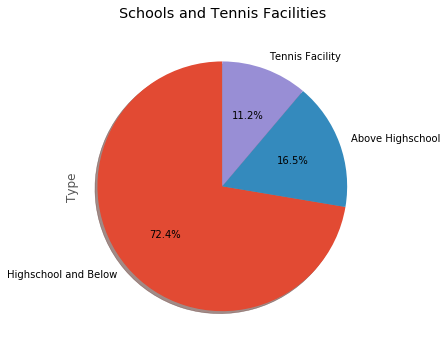

In [355]:

# autopct create %, start angle represent starting point
ST_count['Type'].plot(kind='pie',
                            figsize=(5, 6),
                            autopct='%1.1f%%', # add in percentages
                            startangle=90,     # start angle 90° (Africa)
                            shadow=True,       # add shadow      
                            )

plt.title('Schools and Tennis Facilities')
plt.axis('equal') # Sets the pie chart to look like a circle.

plt.show()


Create a dataframe with aggregate values of number of schools and mean distances

In [362]:
SCT_df=pd.DataFrame(Total_df.groupby('Neighborhood').agg({'Above Highschool' : ['sum'],'Highschool and Below' : ['sum'], 'Tennis Facility' : ['sum'],'AHS_dist' : ['mean'],'HSB_dist' : ['mean'],'TF_dist' : ['mean']}).reset_index())
SCT_df.head()


,Neighborhood,Above Highschool,Highschool and Below,Tennis Facility,AHS_dist,HSB_dist,TF_dist
,,sum,sum,sum,mean,mean,mean
0,"Bathurst Manor, Downsview North, Wilson Heights",0,4,0,0.000000,636.500000,0.000000
1,Bayview Village,0,4,0,0.000000,780.000000,0.000000
2,"Bedford Park, Lawrence Manor East",0,8,0,0.000000,691.250000,0.000000
3,"CFB Toronto, Downsview East",1,2,0,237.000000,309.000000,0.000000
4,Don Mills North,2,9,4,33.866667,365.066667,141.733333


Plot a sctter diagram to analyse the various types of venues and distance from center of neighborhood

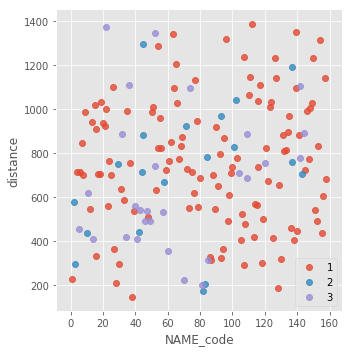

In [360]:
import seaborn as sns
sns.lmplot( x="NAME_code", y="distance", data=Total_df, fit_reg=False, hue='ST_code', legend=False)

# Move the legend to an empty part of the plot
plt.legend(loc='lower right')



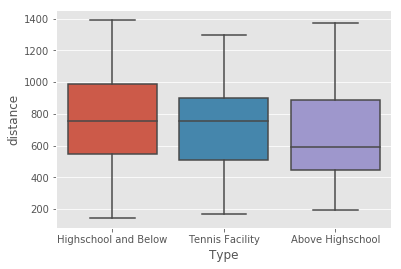

In [359]:
# Draw a box plot see how the distance with neighborhood center in each venue category
sns.boxplot(x="Type", y="distance", data=Total_df)




Bar plot with distance and venue code 

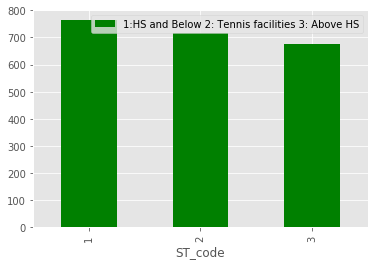

In [287]:
T_P = Total_df.groupby('ST_code',as_index=False).mean()
T_P.plot(kind='bar', x ='ST_code', y='distance',color='g',label='1:HS and Below 2: Tennis facilities 3: Above HS')

Histogram which shows number of venue category 

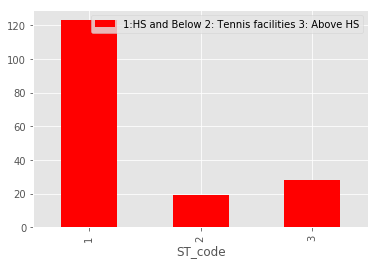

In [284]:
T_P = Total_df.groupby('ST_code',as_index=False).count()
T_P.plot(kind='bar', x ='ST_code', y='sch_no',color='r',label='1:HS and Below 2: Tennis facilities 3: Above HS')

#### K means cluster analysis of neighborhood

In [326]:
# prepare the data frame for cluster analysis
SCT_int=Total_df.groupby("Neighborhood",as_index=False).sum()
SCT_K=[]
SCT_K=pd.DataFrame(columns=['Total Schools','Tennis Facility'])
SCT_K['Total Schools']=SCT_int['Highschool and Below']+SCT_int['Above Highschool']
SCT_K['Tennis Facility']=SCT_int['Tennis Facility']
SCT_K.reset_index(inplace=True)
#SCT_K.drop(columns=['index'])
SCT_K.head()

,index,Total Schools,Tennis Facility
0,0,4,0
1,1,4,0
2,2,8,0
3,3,3,0
4,4,11,4


In [337]:
# set number of clusters
kclusters = 5


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(SCT_K)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:5]

array([1, 1, 1, 1, 1], dtype=int32)

In [333]:
# add clustering labels   
SCT_df.insert(0, 'Cluster Labels', kmeans.labels_)

#### Examin clusters

In [334]:
SCT_df.loc[SCT_df['Cluster Labels'] == 0, SCT_df.columns[[0] + list(range(0, SCT_df.shape[1]))]]

Cluster Labels                         Neighborhood Above Highschool  \
                                                                    sum   
10              0  0      Fairview, Henry Farm, Oriole                3   
12              0  0                         Glencairn                2   
13              0  0                 Hillcrest Village                1   
14              0  0                     Humber Summit                0   
15              0  0  Lawrence Heights, Lawrence Manor                1   
16              0  0           Newtonbrook, Willowdale                3   
18              0  0                         Parkwoods                1   

   Highschool and Below Tennis Facility    AHS_dist    HSB_dist     TF_dist  
                    sum             sum        mean        mean        mean  
10                    9               1  184.769231  594.000000   33.538462  
12                    7               2  151.545455  646.181818  133.000000  
13                    6               2   50.666667  465.111111   97.333333  
14                    3               0    0.000000  727.666667    0.000000  
15                    5               1  158.142857  469.714286  170.285714  
16                    4               0  345.285714  476.285714    0.000000  
18                    8               1  109.700000  592.600000   92.400000

In [313]:
SCT_df.loc[SCT_df['Cluster Labels'] == 1, SCT_df.columns[[0] + list(range(0, SCT_df.shape[1]))]]

Cluster Labels                                        Neighborhood  \
                                                                       
0              1  1  Bathurst Manor, Downsview North, Wilson Heights   
1              1  1                                  Bayview Village   
2              1  1                Bedford Park, Lawrence Manor East   
3              1  1                      CFB Toronto, Downsview East   
4              1  1                                  Don Mills North   
5              1  1                                Downsview Central   
6              1  1                              Downsview Northwest   

  Above Highschool Highschool and Below Tennis Facility    AHS_dist  \
               sum                  sum             sum        mean   
0                0                    4               0    0.000000   
1                0                    4               0    0.000000   
2                0                    8               0    0.000000   
3                1                    2               0  237.000000   
4                2                    9               4   33.866667   
5                1                    6               0  126.714286   
6                1                    6               0  107.857143   

     HSB_dist     TF_dist  
         mean        mean  
0  636.500000    0.000000  
1  780.000000    0.000000  
2  691.250000    0.000000  
3  309.000000    0.000000  
4  365.066667  141.733333  
5  661.142857    0.000000  
6  620.857143    0.000000

In [314]:
SCT_df.loc[SCT_df['Cluster Labels'] == 2, SCT_df.columns[[0] + list(range(0, SCT_df.shape[1]))]]

Cluster Labels         Neighborhood Above Highschool Highschool and Below  \
                                                    sum                  sum   
21              2  2  Willowdale South                8                    9   

   Tennis Facility AHS_dist HSB_dist TF_dist  
               sum     mean     mean    mean  
21               3    215.4    344.3   122.4

In [315]:
SCT_df.loc[SCT_df['Cluster Labels'] == 3, SCT_df.columns[[0] + list(range(0, SCT_df.shape[1]))]]

Cluster Labels                         Neighborhood Above Highschool  \
                                                                    sum   
10              3  3      Fairview, Henry Farm, Oriole                3   
12              3  3                         Glencairn                2   
13              3  3                 Hillcrest Village                1   
15              3  3  Lawrence Heights, Lawrence Manor                1   
16              3  3           Newtonbrook, Willowdale                3   
18              3  3                         Parkwoods                1   

   Highschool and Below Tennis Facility    AHS_dist    HSB_dist     TF_dist  
                    sum             sum        mean        mean        mean  
10                    9               1  184.769231  594.000000   33.538462  
12                    7               2  151.545455  646.181818  133.000000  
13                    6               2   50.666667  465.111111   97.333333  
15                    5               1  158.142857  469.714286  170.285714  
16                    4               0  345.285714  476.285714    0.000000  
18                    8               1  109.700000  592.600000   92.400000

In [316]:
SCT_df.loc[SCT_df['Cluster Labels'] == 4, SCT_df.columns[[0] + list(range(0, SCT_df.shape[1]))]]

Cluster Labels                           Neighborhood Above Highschool  \
                                                                      sum   
7               4  4                      Downsview West                1   
8               4  4  Downsview, North Park, Upwood Park                0   
9               4  4                    Emery, Humberlea                0   
11              4  4    Flemingdon Park, Don Mills South                0   
14              4  4                       Humber Summit                0   

   Highschool and Below Tennis Facility    AHS_dist    HSB_dist TF_dist  
                    sum             sum        mean        mean    mean  
7                     5               0  114.333333  728.500000     0.0  
8                     5               0    0.000000  843.600000     0.0  
9                     1               0    0.000000  680.000000     0.0  
11                    2               0    0.000000  821.500000     0.0  
14                    3               0    0.000000  727.666667     0.0

# Result

Various analysis shows in many neighborhoods there is no Tennis facilities for students. Cluster nalysis shows in cluster 5 and cluster 2 (Total 12 neighborhoods) except for 1 neighborhood, there is no Tennis facility. Number of schools in those neighborhood varies between 1 and 8.   

### Final Recommendation

The neighborhoods belongs to cluster 2 and Cluster 5 have 0 Tennis facilities. Neighborhoods without any Tennis facility are Bathurst Manor, Downsview North, Wilson Heights,Bayview Village,Bedford Park, Lawrence Manor East,CFB Toronto, Downsview East, Downsview Central,	Downsview Northwest,Downsview West, Downsview, North Park, Upwood Park, Emery, Humberlea, Flemingdon Park, Don Mills South, Humber Summit. Among these neighborhood, Bedford Park, Lawrence Manor East has eight educational institutions but there is no facility for Tennis. So this neighborhood is the most required neighborhood to build a new Tennis facility. Next recommendation is to Downsview Central and Downsview Northwest (7 institutions benefitted).   